In [1]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer

2023-10-10 20:07:42.362677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 20:07:43.106124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.12 (you have 3.10.4)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
import os
import cv2

In [3]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe.to('cuda')

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/home/jacklishufan/miniconda3/envs/uninext/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

/home/jacklishufan/UNINEXT/notebooks


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from detectron2.projects.hipie.demo_lib.part_segm_demo import PartSegmDemo
from detectron2.data.detection_utils import read_image,convert_PIL_to_numpy

In [7]:
config_file = 'projects/HIPIE/configs/training/r50_parts.yaml'
ckpt = 'public/r50_parts.pth'
uninext_demo = PartSegmDemo(config_file=config_file,weight=ckpt)

Some model parameters or buffers are not found in the checkpoint:
detr.mask_dino.predictor.resizer.fc.{bias, weight}
detr.mask_dino.predictor.resizer.layer_norm.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.body.model.embeddings.position_ids
  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133
Length of pascal_parts_val Categories : 200
Length of coco_2017_train_panoptic_with_sem_seg Categories : 133


In [8]:
url = 'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
image = Image.open(requests.get(url,stream=True).raw)
image_np_d2 = convert_PIL_to_numpy(image, format="BGR")

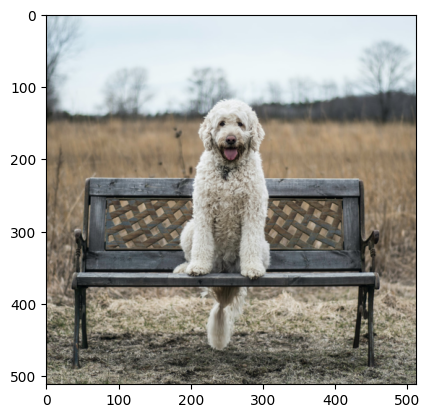

In [9]:
image = image.crop((0,0,image.width,image.width)).resize((512,512))
plt.imshow(image)

In [10]:
image_np_d2 = convert_PIL_to_numpy(image, format="BGR")

In [11]:
mask = uninext_demo.foward_reference(image_np_d2,"the dog","head",use_coarse=True)

/home/jacklishufan/miniconda3/envs/uninext/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/jacklishufan/miniconda3/envs/uninext/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/jacklishufan/miniconda3/envs/uninext/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients 

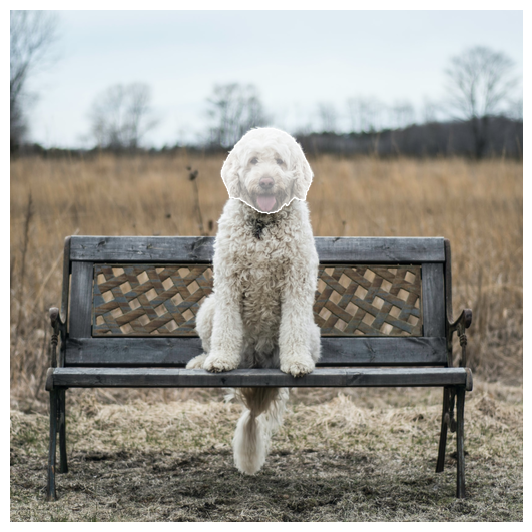

In [12]:
vis= Visualizer(image)
#vis.overlay_instances(masks=mask['instance_mask'])
#vis.overlay_instances(masks=part_mask)
vis.overlay_instances(masks=[mask['final_mask'][0].numpy()])
vis.get_output().fig

In [37]:
img_dilation = mask['final_mask'][0].numpy()
DILATION_SIZE = 100
kernel = np.ones((DILATION_SIZE, DILATION_SIZE), np.uint8)
img_dilation = cv2.dilate(img_dilation, kernel, iterations=1)
#plt.imshow(img_dilation)

In [38]:
def resize(img,mask,tgt_size=(512,512)):
    new_img = image.resize(tgt_size)
    mask = torch.tensor(mask)[None,None,]
    mask = torch.nn.functional.interpolate(mask,tgt_size)
    return new_img,mask[0][0].numpy()

In [39]:
mask_image = img_dilation

In [40]:
img_resized,mask_resized = resize(image,mask_image)

In [43]:
prompt = "Face of an elephant"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_repaint = pipe(prompt=prompt, image=img_resized, mask_image=mask_resized).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

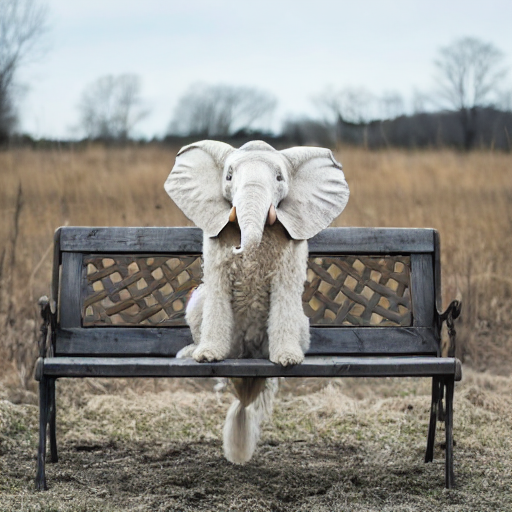

In [44]:
image_repaint